# 14. Advanced Panel Data Methods

Advanced panel data methods provide researchers with powerful tools for addressing endogeneity arising from time-invariant unobserved heterogeneity. This chapter develops the fixed effects (FE) and random effects (RE) estimators, establishing the theoretical foundations, computational procedures, and inferential frameworks that make these approaches central to modern applied econometric analysis.

The development proceeds systematically through the panel data toolkit. We establish the fixed effects estimator as the within transformation that eliminates individual-specific effects (Section 14.1), introduce the random effects estimator under the assumption that individual effects are uncorrelated with regressors (Section 14.2), develop the Hausman test for choosing between FE and RE specifications along with correlated random effects approaches that bridge the two methods (Section 14.3), examine robust inference procedures including clustered standard errors for panel data (Section 14.4), and extend these methods to unbalanced panels, repeated cross sections, and policy evaluation contexts (Section 14.5). Throughout, we implement estimators using Python's linearmodels package and demonstrate applications to labor economics, health economics, and development studies.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge linearmodels scipy -q

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import wooldridge as wool
from IPython.display import display
from linearmodels import PanelOLS, RandomEffects

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 14.1 Fixed Effects Estimation

The **fixed effects** (FE) estimator, also called the **within estimator**, removes the unobserved individual effect $a_i$ by de-meaning all variables. This is one of the most widely used panel data estimators in economics.

### The Fixed Effects Model

Consider the standard panel data model with unobserved heterogeneity:

$$ y_{it} = \beta_1 x_{1,it} + \beta_2 x_{2,it} + \ldots + \beta_k x_{k,it} + a_i + u_{it} $$

where:
- $a_i$ = individual-specific unobserved effect (time-invariant)
- $u_{it}$ = idiosyncratic error (varies over $i$ and $t$)
- The key problem: $a_i$ may be correlated with the $x$ variables

### The Within Transformation

The FE estimator eliminates $a_i$ by subtracting the individual-specific time average from each variable:

$$ \ddot{y}_{it} = y_{it} - \bar{y}_i = \beta_1 \ddot{x}_{1,it} + \ldots + \beta_k \ddot{x}_{k,it} + \ddot{u}_{it} $$

where $\bar{y}_i = T_i^{-1} \sum_{t=1}^{T_i} y_{it}$ is the time average for individual $i$, and $\ddot{y}_{it} = y_{it} - \bar{y}_i$ is the de-meaned (or "within") transformation.

Notice that $a_i$ has disappeared because $a_i - a_i = 0$!

### Properties of the FE Estimator

1. **Consistency**: FE is consistent even if $a_i$ is correlated with the $x$ variables
2. **Strict exogeneity required**: $E(u_{it}|x_{i1}, \ldots, x_{iT}, a_i) = 0$ for all $t$
3. **Time-invariant variables**: Cannot estimate effects of variables that don't change over time
4. **Standard errors**: Should be clustered at the individual level to account for serial correlation

### Example 14.1: Effect of Job Training on Firm Productivity

We'll analyze whether job training grants improve firm productivity using data on manufacturing firms. The outcome is the (log) scrap rate, and we control for unobserved firm characteristics that might affect both training and productivity.

In [3]:
# Load job training panel data
jtrain = wool.data("jtrain")

print("Dataset Information:")
print(f"Total observations: {len(jtrain)}")
print(f"Number of firms: {jtrain['fcode'].nunique()}")
print(f"Years: {sorted(jtrain['year'].unique())}")
print(f"Time periods per firm: {len(jtrain['year'].unique())}")

# Display variable descriptions
print("\nKey Variables:")
print("- lscrap: log(scrap rate) - our outcome variable")
print("- d88, d89: year dummies for 1988 and 1989")
print("- grant: =1 if firm received grant this year")
print("- grant_1: =1 if firm received grant last year")
print("- fcode: firm identifier")

# Show first observations for a few firms
display(jtrain.head(15))

Dataset Information:
Total observations: 471
Number of firms: 157
Years: [np.int64(1987), np.int64(1988), np.int64(1989)]
Time periods per firm: 3

Key Variables:
- lscrap: log(scrap rate) - our outcome variable
- d88, d89: year dummies for 1988 and 1989
- grant: =1 if firm received grant this year
- grant_1: =1 if firm received grant last year
- fcode: firm identifier


,year,fcode,employ,sales,avgsal,scrap,rework,tothrs,union,grant,...,grant_1,clscrap,cgrant,clemploy,clsales,lavgsal,clavgsal,cgrant_1,chrsemp,clhrsemp
0,1987,410032.0,100.0,47000000.0,35000.0,NaN,NaN,12.0,0,0,...,0,NaN,0,NaN,NaN,10.463103,NaN,NaN,NaN,NaN
1,1988,410032.0,131.0,43000000.0,37000.0,NaN,NaN,8.0,0,0,...,0,NaN,0,0.270027,-0.088949,10.518673,0.055570,0.0,-8.946565,-1.165385
2,1989,410032.0,123.0,49000000.0,39000.0,NaN,NaN,8.0,0,0,...,0,NaN,0,-0.063013,0.130621,10.571317,0.052644,0.0,0.198597,0.047832
3,1987,410440.0,12.0,1560000.0,10500.0,NaN,NaN,12.0,0,0,...,0,NaN,0,NaN,NaN,9.259130,NaN,NaN,NaN,NaN
4,1988,410440.0,13.0,1970000.0,11000.0,NaN,NaN,12.0,0,0,...,0,NaN,0,0.080043,0.233347,9.305651,0.046520,0.0,0.000000,0.000000
5,1989,410440.0,14.0,2350000.0,11500.0,NaN,NaN,10.0,0,0,...,0,NaN,0,0.074108,0.176382,9.350102,0.044452,0.0,-2.000000,-0.167054
6,1987,410495.0,20.0,750000.0,17680.0,NaN,NaN,50.0,0,0,...,0,NaN,0,NaN,NaN,9.780190,NaN,NaN,NaN,NaN
7,1988,410495.0,25.0,110000.0,18720.0,NaN,NaN,50.0,0,0,...,0,NaN,0,0.223144,-1.919593,9.837348,0.057158,0.0,-17.500000,-0.606136
8,1989,410495.0,24.0,950000.0,19760.0,NaN,NaN,50.0,0,0,...,0,NaN,0,-0.040822,2.155982,9.891415,0.054067,0.0,21.666668,0.708895
9,1987,410500.0,200.0,23741000.0,13729.0,NaN,NaN,0.0,0,0,...,0,NaN,0,NaN,NaN,9.527266,NaN,NaN,NaN,NaN


In [4]:
# Summary statistics
key_vars = ["lscrap", "grant", "grant_1", "d88", "d89"]
print("Summary Statistics:")
display(jtrain[key_vars].describe().round(4))

Summary Statistics:


,lscrap,grant,grant_1,d88,d89
count,162.0000,471.0000,471.0000,471.0000,471.0000
mean,0.3937,0.1401,0.0764,0.3333,0.3333
std,1.4865,0.3475,0.2660,0.4719,0.4719
min,-4.6052,0.0000,0.0000,0.0000,0.0000
25%,-0.5234,0.0000,0.0000,0.0000,0.0000
50%,0.3471,0.0000,0.0000,0.0000,0.0000
75%,1.3863,0.0000,0.0000,1.0000,1.0000
max,3.4012,1.0000,1.0000,1.0000,1.0000


#### Manual Fixed Effects Estimation

To understand FE intuitively, let's first estimate it manually by de-meaning the variables:

In [5]:
# Set up panel structure
jtrain_panel = jtrain.copy()
jtrain_panel["entity"] = jtrain_panel["fcode"]
jtrain_panel = jtrain_panel.set_index(["fcode", "year"])

# Manual computation: subtract entity (firm) means from each variable
# The suffix '_w' denotes "within" (de-meaned) variables
jtrain_panel["lscrap_w"] = jtrain_panel["lscrap"] - jtrain_panel.groupby("fcode")[
    "lscrap"
].transform("mean")
jtrain_panel["d88_w"] = jtrain_panel["d88"] - jtrain_panel.groupby("fcode")[
    "d88"
].transform("mean")
jtrain_panel["d89_w"] = jtrain_panel["d89"] - jtrain_panel.groupby("fcode")[
    "d89"
].transform("mean")
jtrain_panel["grant_w"] = jtrain_panel["grant"] - jtrain_panel.groupby("fcode")[
    "grant"
].transform("mean")
jtrain_panel["grant_1_w"] = jtrain_panel["grant_1"] - jtrain_panel.groupby("fcode")[
    "grant_1"
].transform("mean")

print("Manual de-meaning completed")
print("\nExample: First firm's de-meaned values")
first_firm = jtrain_panel.index.get_level_values(0).unique()[0]
display(jtrain_panel.loc[first_firm, ["lscrap", "lscrap_w", "grant", "grant_w"]])

Manual de-meaning completed

Example: First firm's de-meaned values


,lscrap,lscrap_w,grant,grant_w
year,,,,
1987,NaN,NaN,0,0.0
1988,NaN,NaN,0,0.0
1989,NaN,NaN,0,0.0


In [6]:
# Estimate FE model manually using OLS on de-meaned data
# Note: no intercept (0 +) because de-meaned data has mean zero
model_manual = smf.ols(
    formula="lscrap_w ~ 0 + d88_w + d89_w + grant_w + grant_1_w",
    data=jtrain_panel,
)
results_manual = model_manual.fit()

print("MANUAL FIXED EFFECTS ESTIMATION")
print("=" * 70)
print("(Estimated using OLS on de-meaned variables)")
print()

table_manual = pd.DataFrame(
    {
        "Coefficient": results_manual.params,
        "Std. Error": results_manual.bse,
        "t-statistic": results_manual.tvalues,
        "p-value": results_manual.pvalues,
    },
)
display(table_manual.round(4))
print(f"\nR-squared (within): {results_manual.rsquared:.4f}")
print(f"Observations: {int(results_manual.nobs)}")

MANUAL FIXED EFFECTS ESTIMATION
(Estimated using OLS on de-meaned variables)



,Coefficient,Std. Error,t-statistic,p-value
d88_w,-0.0802,0.0888,-0.9031,0.3678
d89_w,-0.2472,0.1081,-2.2872,0.0235
grant_w,-0.2523,0.1222,-2.0646,0.0406
grant_1_w,-0.4216,0.1705,-2.4721,0.0145



R-squared (within): 0.2010
Observations: 162


#### Automatic Fixed Effects Estimation

Now let's use the specialized `PanelOLS` estimator with `EntityEffects`, which handles everything automatically:

In [7]:
# Automatic FE estimation using linearmodels
# EntityEffects automatically includes individual fixed effects
# TimeEffects automatically includes time fixed effects
model_auto = PanelOLS.from_formula(
    formula="lscrap ~ d88 + d89 + grant + grant_1 + EntityEffects",
    data=jtrain_panel,
)
results_auto = model_auto.fit(cov_type="clustered", cluster_entity=True)

print("\nAUTOMATIC FIXED EFFECTS ESTIMATION")
print("=" * 70)
print("(Using PanelOLS with EntityEffects and clustered SEs)")
print()

table_auto = pd.DataFrame(
    {
        "Coefficient": results_auto.params,
        "Std. Error": results_auto.std_errors,
        "t-statistic": results_auto.tstats,
        "p-value": results_auto.pvalues,
    },
)
display(table_auto.round(4))
print(f"\nR-squared (within): {results_auto.rsquared_within:.4f}")
print(f"R-squared (overall): {results_auto.rsquared_overall:.4f}")
print(f"Observations: {results_auto.nobs}")
print(f"Entities (firms): {results_auto.entity_info['total']}")


AUTOMATIC FIXED EFFECTS ESTIMATION
(Using PanelOLS with EntityEffects and clustered SEs)



/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


,Coefficient,Std. Error,t-statistic,p-value
d88,-0.0802,0.0969,-0.8276,0.4098
d89,-0.2472,0.1949,-1.2681,0.2076
grant,-0.2523,0.1421,-1.7757,0.0787
grant_1,-0.4216,0.2798,-1.5067,0.1349



R-squared (within): 0.2010
R-squared (overall): -0.0839
Observations: 162
Entities (firms): 54.0


In [8]:
# Compare manual and automatic estimates
print("\nCOMPARISON: Manual vs Automatic FE Estimates")
print("=" * 70)

comparison = pd.DataFrame(
    {
        "Manual FE": results_manual.params,
        "Automatic FE": results_auto.params,
        "Difference": results_manual.params - results_auto.params,
    },
)
display(comparison.round(6))

print("\nNote: Coefficients are identical (differences due to rounding).")
print("Standard errors differ because automatic FE uses clustered SEs.")


COMPARISON: Manual vs Automatic FE Estimates


,Manual FE,Automatic FE,Difference
d88,NaN,-0.080216,NaN
d88_w,-0.080216,NaN,NaN
d89,NaN,-0.247203,NaN
d89_w,-0.247203,NaN,NaN
grant,NaN,-0.252315,NaN
grant_1,NaN,-0.421590,NaN
grant_1_w,-0.421590,NaN,NaN
grant_w,-0.252315,NaN,NaN



Note: Coefficients are identical (differences due to rounding).
Standard errors differ because automatic FE uses clustered SEs.


In [9]:
# Interpretation of results
print("\nINTERPRETATION OF FIXED EFFECTS ESTIMATES:")
print("=" * 70)

grant_coef = results_auto.params["grant"]
grant_se = results_auto.std_errors["grant"]
grant_1_coef = results_auto.params["grant_1"]

print(f"\n1. Current Year Grant Effect: {grant_coef:.4f}")
if abs(grant_coef / grant_se) < 1.96:
    print(
        "   The grant has NO statistically significant effect on scrap rates this year",
    )
    print(
        f"   (t-stat = {grant_coef / grant_se:.2f}, p-value = {results_auto.pvalues['grant']:.3f})"
    )
else:
    print(
        f"   The grant {'reduces' if grant_coef < 0 else 'increases'} log(scrap) by {abs(grant_coef):.4f}",
    )
    print(
        f"   This is approximately a {100 * abs(grant_coef):.2f}% change in scrap rates"
    )

print(f"\n2. Lagged Grant Effect (grant_1): {grant_1_coef:.4f}")
print(
    f"   Receiving a grant LAST year {'reduces' if grant_1_coef < 0 else 'increases'} log(scrap) by {abs(grant_1_coef):.4f}",
)
print(
    f"   This is approximately a {100 * abs(grant_1_coef):.2f}% change in scrap rates"
)
print("   (The effect may take time to materialize as workers apply new skills)")

print("\n3. Firm Fixed Effects:")
print("   The model controls for all time-invariant firm characteristics:")
print("   - Management quality")
print("   - Firm culture and organization")
print("   - Geographic location")
print("   - Industry-specific factors")
print("   - Any other unobserved factors that don't change over time")


INTERPRETATION OF FIXED EFFECTS ESTIMATES:

1. Current Year Grant Effect: -0.2523
   The grant has NO statistically significant effect on scrap rates this year
   (t-stat = -1.78, p-value = 0.079)

2. Lagged Grant Effect (grant_1): -0.4216
   Receiving a grant LAST year reduces log(scrap) by 0.4216
   This is approximately a 42.16% change in scrap rates
   (The effect may take time to materialize as workers apply new skills)

3. Firm Fixed Effects:
   The model controls for all time-invariant firm characteristics:
   - Management quality
   - Firm culture and organization
   - Geographic location
   - Industry-specific factors
   - Any other unobserved factors that don't change over time


### Visualizing the Fixed Effects

/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77226/3398153719.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jtrain_selected["firm_category"] = jtrain_selected["fcode"].apply(
/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77226/3398153719.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(


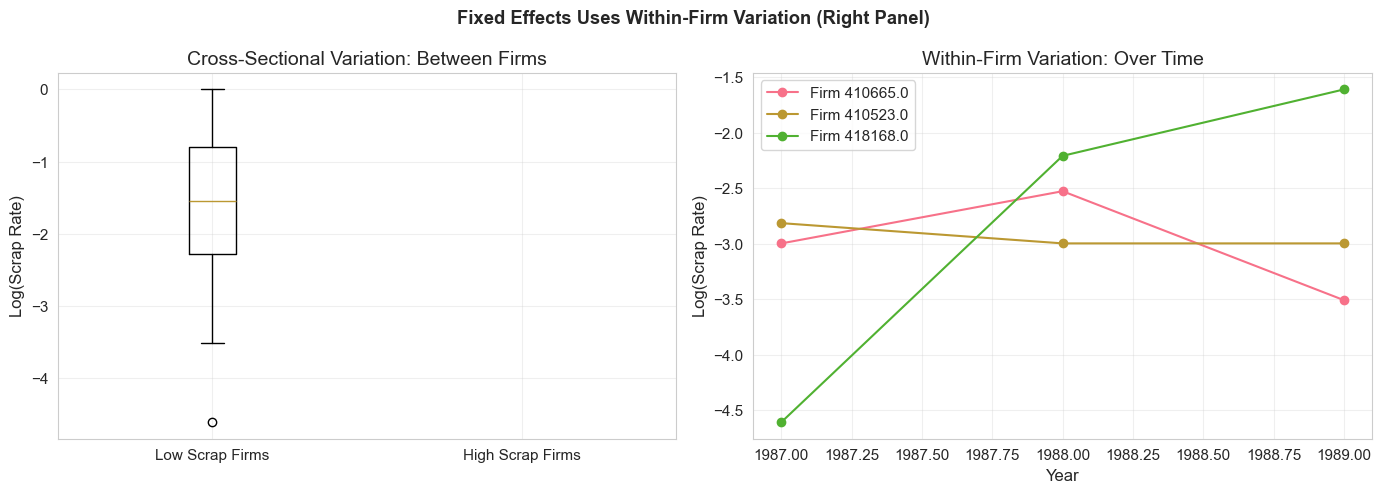

In [10]:
# Visualize variation in scrap rates across firms and over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Variation across firms (box plots)
firm_means = jtrain.groupby("fcode")["lscrap"].mean().sort_values()
top_10_firms = firm_means.head(10).index
bottom_10_firms = firm_means.tail(10).index
selected_firms = list(top_10_firms) + list(bottom_10_firms)

jtrain_selected = jtrain[jtrain["fcode"].isin(selected_firms)]
jtrain_selected["firm_category"] = jtrain_selected["fcode"].apply(
    lambda x: "Low scrap" if x in top_10_firms else "High scrap",
)

axes[0].boxplot(
    [
        jtrain_selected[jtrain_selected["firm_category"] == "Low scrap"]["lscrap"],
        jtrain_selected[jtrain_selected["firm_category"] == "High scrap"]["lscrap"],
    ],
    labels=["Low Scrap Firms", "High Scrap Firms"],
)
axes[0].set_ylabel("Log(Scrap Rate)")
axes[0].set_title("Cross-Sectional Variation: Between Firms")
axes[0].grid(True, alpha=0.3)

# Panel B: Within-firm variation over time (selected firms)
for firm in list(top_10_firms)[:3]:
    firm_data = jtrain[jtrain["fcode"] == firm].sort_values("year")
    axes[1].plot(
        firm_data["year"], firm_data["lscrap"], marker="o", label=f"Firm {firm}"
    )

axes[1].set_xlabel("Year")
axes[1].set_ylabel("Log(Scrap Rate)")
axes[1].set_title("Within-Firm Variation: Over Time")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(
    "Fixed Effects Uses Within-Firm Variation (Right Panel)", fontweight="bold"
)
plt.tight_layout()
plt.show()

## 14.2 Random Effects Estimation

The **random effects** (RE) estimator is a **generalized least squares** (GLS) estimator that can be more efficient than FE when the unobserved effect is uncorrelated with the explanatory variables.

### The Random Effects Model

The RE model assumes:

$$ y_{it} = \beta_0 + \beta_1 x_{1,it} + \ldots + \beta_k x_{k,it} + a_i + u_{it} $$

**Key RE assumption**: $E(a_i | x_{i1}, \ldots, x_{iT}) = \beta_0$

This means $a_i$ is **uncorrelated** with all $x$ variables. This is a strong assumption!

### Why Random Effects?

**Efficiency**: If the RE assumption holds, RE is more efficient than FE
**Time-invariant variables**: RE can estimate effects of variables that don't vary over time
**Between variation**: RE uses both within and between variation

### The RE Transformation

RE uses a **quasi-demeaning** transformation:

$$ y_{it} - \theta \bar{y}_i = \beta_0(1-\theta) + \beta_1(x_{1,it} - \theta \bar{x}_{1,i}) + \ldots + v_{it} $$

where:
- $\theta = 1 - \sqrt{\sigma_u^2 / (\sigma_u^2 + T\sigma_a^2)}$
- $\theta \in [0, 1]$ depending on the relative importance of $a_i$ vs $u_{it}$
- If $\theta = 1$: RE reduces to FE (full de-meaning)
- If $\theta = 0$: RE reduces to pooled OLS (no de-meaning)

### Example 14.2: Wage Equation with Time-Varying Education Returns

We'll estimate the returns to education, marriage, and union membership using a panel of male workers.

In [11]:
# Load wage panel data
wagepan = wool.data("wagepan")

print("Dataset Information:")
print(f"Total observations: {len(wagepan)}")
print(f"Number of individuals: {wagepan['nr'].nunique()}")
print(f"Years: {sorted(wagepan['year'].unique())}")
print(f"Observations per person: {len(wagepan) / wagepan['nr'].nunique():.1f}")

print("\nKey Variables:")
print("- lwage: log(wage)")
print("- educ: years of education (time-invariant for most)")
print("- married: =1 if married")
print("- union: =1 if union member")
print("- nr: person identifier")

display(wagepan.head(12))

Dataset Information:
Total observations: 4360
Number of individuals: 545
Years: [np.int64(1980), np.int64(1981), np.int64(1982), np.int64(1983), np.int64(1984), np.int64(1985), np.int64(1986), np.int64(1987)]
Observations per person: 8.0

Key Variables:
- lwage: log(wage)
- educ: years of education (time-invariant for most)
- married: =1 if married
- union: =1 if union member
- nr: person identifier


,nr,year,agric,black,bus,construc,ent,exper,fin,hisp,...,union,lwage,d81,d82,d83,d84,d85,d86,d87,expersq
0,13,1980,0,0,1,0,0,1,0,0,...,0,1.197540,0,0,0,0,0,0,0,1
1,13,1981,0,0,0,0,0,2,0,0,...,1,1.853060,1,0,0,0,0,0,0,4
2,13,1982,0,0,1,0,0,3,0,0,...,0,1.344462,0,1,0,0,0,0,0,9
3,13,1983,0,0,1,0,0,4,0,0,...,0,1.433213,0,0,1,0,0,0,0,16
4,13,1984,0,0,0,0,0,5,0,0,...,0,1.568125,0,0,0,1,0,0,0,25
5,13,1985,0,0,1,0,0,6,0,0,...,0,1.699891,0,0,0,0,1,0,0,36
6,13,1986,0,0,1,0,0,7,0,0,...,0,-0.720263,0,0,0,0,0,1,0,49
7,13,1987,0,0,1,0,0,8,0,0,...,0,1.669188,0,0,0,0,0,0,1,64
8,17,1980,0,0,0,0,0,4,0,0,...,0,1.675962,0,0,0,0,0,0,0,16
9,17,1981,0,0,0,0,0,5,0,0,...,0,1.518398,1,0,0,0,0,0,0,25


In [12]:
# Set up panel structure
wagepan_panel = wagepan.set_index(["nr", "year"], drop=False)

# Summary statistics
print("Summary Statistics:")
display(wagepan[["lwage", "educ", "married", "union", "exper"]].describe().round(3))

Summary Statistics:


,lwage,educ,married,union,exper
count,4360.000,4360.000,4360.000,4360.000,4360.000
mean,1.649,11.767,0.439,0.244,6.515
std,0.533,1.746,0.496,0.430,2.826
min,-3.579,3.000,0.000,0.000,0.000
25%,1.351,11.000,0.000,0.000,4.000
50%,1.671,12.000,0.000,0.000,6.000
75%,1.991,12.000,1.000,0.000,9.000
max,4.052,16.000,1.000,1.000,18.000


We want to allow education returns to vary by year (perhaps due to skill-biased technological change):

In [13]:
# Fixed Effects model with time-varying education returns
# C(year)*educ creates interactions between year dummies and education
# year is already a column since we used drop=False in set_index
fe_model = PanelOLS.from_formula(
    formula="lwage ~ married + union + C(year)*educ + EntityEffects",
    data=wagepan_panel,
    drop_absorbed=True,  # Don't show individual dummies
)
fe_results = fe_model.fit(cov_type="clustered", cluster_entity=True)

print("FIXED EFFECTS ESTIMATION: Time-Varying Returns to Education")
print("=" * 70)

fe_table = pd.DataFrame(
    {
        "Coefficient": fe_results.params,
        "Std. Error": fe_results.std_errors,
        "t-statistic": fe_results.tstats,
        "p-value": fe_results.pvalues,
    },
)
display(fe_table.round(4))
print(f"\nR-squared (within): {fe_results.rsquared_within:.4f}")
print(f"Observations: {fe_results.nobs}")

FIXED EFFECTS ESTIMATION: Time-Varying Returns to Education


/var/folders/rg/vmn_nq41613gkxt0_9spwzx80000gp/T/ipykernel_77226/264589140.py:9: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

educ

  fe_results = fe_model.fit(cov_type="clustered", cluster_entity=True)


,Coefficient,Std. Error,t-statistic,p-value
married,0.0548,0.0212,2.5869,0.0097
union,0.0830,0.0230,3.6051,0.0003
C(year)[1980],1.3625,0.0203,67.0427,0.0000
C(year)[1981],1.3400,0.1448,9.2552,0.0000
C(year)[1982],1.3567,0.1390,9.7632,0.0000
C(year)[1983],1.3729,0.1536,8.9365,0.0000
C(year)[1984],1.4468,0.1594,9.0756,0.0000
C(year)[1985],1.4122,0.1574,8.9719,0.0000
C(year)[1986],1.4281,0.1714,8.3324,0.0000
C(year)[1987],1.4529,0.1577,9.2134,0.0000



R-squared (within): 0.1708
Observations: 4360


In [14]:
# Interpretation
print("\nINTERPRETATION OF FE RESULTS:")
print("=" * 70)

married_coef = fe_results.params["married"]
union_coef = fe_results.params["union"]

print(f"\n1. Marriage Premium: {married_coef:.4f}")
print(f"   Being married increases log(wage) by {married_coef:.4f}")
print(f"   Approximately {100 * married_coef:.2f}% higher wages for married men")

print(f"\n2. Union Premium: {union_coef:.4f}")
print(f"   Union membership increases log(wage) by {union_coef:.4f}")
print(f"   Approximately {100 * union_coef:.2f}% higher wages for union members")

print("\n3. Education Returns by Year:")
print("   Base year return captured by year fixed effects")
print("   Interaction terms show how returns changed over time")

# Extract education*year interactions
educ_interactions = {
    k: v for k, v in fe_results.params.items() if "educ" in k and ":" in k
}
if educ_interactions:
    print("\n   Year-specific changes in education returns:")
    for term, coef in educ_interactions.items():
        print(f"   {term}: {coef:.4f}")


INTERPRETATION OF FE RESULTS:

1. Marriage Premium: 0.0548
   Being married increases log(wage) by 0.0548
   Approximately 5.48% higher wages for married men

2. Union Premium: 0.0830
   Union membership increases log(wage) by 0.0830
   Approximately 8.30% higher wages for union members

3. Education Returns by Year:
   Base year return captured by year fixed effects
   Interaction terms show how returns changed over time

   Year-specific changes in education returns:
   C(year)[T.1981]:educ: 0.0116
   C(year)[T.1982]:educ: 0.0148
   C(year)[T.1983]:educ: 0.0171
   C(year)[T.1984]:educ: 0.0166
   C(year)[T.1985]:educ: 0.0237
   C(year)[T.1986]:educ: 0.0274
   C(year)[T.1987]:educ: 0.0304


## 14.3 The Correlated Random Effects Approach

The **Correlated Random Effects** (CRE) approach, developed by Chamberlain (1982) and Mundlak (1978), provides a middle ground between FE and RE. It allows correlation between $a_i$ and the $x$ variables in a flexible way.

### The CRE Specification

The key idea: model the correlation between $a_i$ and $x_{it}$ explicitly:

$$ a_i = \psi_0 + \psi_1 \bar{x}_{1,i} + \psi_2 \bar{x}_{2,i} + \ldots + \psi_k \bar{x}_{k,i} + r_i $$

where $\bar{x}_{j,i} = T_i^{-1} \sum_{t=1}^{T_i} x_{j,it}$ is the time average of variable $j$ for individual $i$.

Substituting into the original model:

$$ y_{it} = \beta_0 + \beta_1 x_{1,it} + \ldots + \beta_k x_{k,it} + \psi_1 \bar{x}_{1,i} + \ldots + \psi_k \bar{x}_{k,i} + r_i + u_{it} $$

Now $r_i$ is uncorrelated with all $x$ variables (by construction), so we can use RE methods!

### Interpretation of CRE Coefficients

- $\beta_j$ = **within effect** (same as FE estimate)
- $\beta_j + \psi_j$ = **overall effect** including between variation
- $\psi_j$ = difference between overall and within effects
- If $\psi_j = 0$: no correlation between $a_i$ and $x_j$ (RE assumption holds)

### Example: CRE Wage Equation

Let's estimate the wage equation using CRE to test whether marriage and union status are correlated with unobserved ability ($a_i$):

In [15]:
# Prepare data for CRE
wagepan_cre = wagepan.copy()
wagepan_cre["t"] = wagepan_cre["year"]
wagepan_cre["entity"] = wagepan_cre["nr"]

# Create time-averages (group means) for time-varying variables
# The suffix '_b' denotes "between" (time average)
wagepan_cre["married_b"] = wagepan_cre.groupby("nr")["married"].transform("mean")
wagepan_cre["union_b"] = wagepan_cre.groupby("nr")["union"].transform("mean")

# Set panel index, keeping year as column for formulas
wagepan_cre = wagepan_cre.set_index(["nr", "year"], drop=False)

print("Created time-averaged variables:")
print("married_b: time average of married status for each person")
print("union_b: time average of union status for each person")
print("\nFirst few observations:")
display(wagepan_cre[["lwage", "married", "married_b", "union", "union_b"]].head(12))

Created time-averaged variables:
married_b: time average of married status for each person
union_b: time average of union status for each person

First few observations:


lwage  married  married_b  union  union_b
nr year                                              
13 1980  1.197540        0        0.0      0    0.125
   1981  1.853060        0        0.0      1    0.125
   1982  1.344462        0        0.0      0    0.125
   1983  1.433213        0        0.0      0    0.125
   1984  1.568125        0        0.0      0    0.125
   1985  1.699891        0        0.0      0    0.125
   1986 -0.720263        0        0.0      0    0.125
   1987  1.669188        0        0.0      0    0.125
17 1980  1.675962        0        0.0      0    0.000
   1981  1.518398        0        0.0      0    0.000
   1982  1.559191        0        0.0      0    0.000
   1983  1.725410        0        0.0      0    0.000

In [16]:
# Estimate CRE model using Random Effects
# Include both the original variables AND their time averages
cre_model = RandomEffects.from_formula(
    formula="lwage ~ married + union + educ + black + hisp + married_b + union_b",
    data=wagepan_cre,
)
cre_results = cre_model.fit(cov_type="clustered", cluster_entity=True)

print("CORRELATED RANDOM EFFECTS ESTIMATION")
print("=" * 70)

cre_table = pd.DataFrame(
    {
        "Coefficient": cre_results.params,
        "Std. Error": cre_results.std_errors,
        "t-statistic": cre_results.tstats,
        "p-value": cre_results.pvalues,
    },
)
display(cre_table.round(4))
print(f"\nObservations: {cre_results.nobs}")

CORRELATED RANDOM EFFECTS ESTIMATION


,Coefficient,Std. Error,t-statistic,p-value
married,0.2417,0.0220,10.9935,0.0000
union,0.0700,0.0251,2.7858,0.0054
educ,0.1257,0.0024,52.0726,0.0000
black,-0.0892,0.0514,-1.7360,0.0826
hisp,0.0784,0.0403,1.9461,0.0517
married_b,-0.0436,0.0460,-0.9463,0.3440
union_b,0.2105,0.0490,4.3000,0.0000



Observations: 4360


In [17]:
# Interpretation and hypothesis testing
print("\nINTERPRETATION OF CRE RESULTS:")
print("=" * 70)

# Within effects (same as FE)
married_within = cre_results.params["married"]
union_within = cre_results.params["union"]

# Between effects (time-averaged variables)
married_between = cre_results.params["married_b"]
union_between = cre_results.params["union_b"]

print("\n1. WITHIN EFFECTS (changes over time):")
print(f"   married: {married_within:.4f}")
print(f"   Getting married increases wages by {100 * married_within:.2f}%")
print(f"\n   union: {union_within:.4f}")
print(f"   Joining a union increases wages by {100 * union_within:.2f}%")

print("\n2. BETWEEN EFFECTS (time-averaged):")
print(f"   married_b: {married_between:.4f}")
if abs(married_between / cre_results.std_errors["married_b"]) > 1.96:
    print(
        "   Men who are married more often have "
        f"{'higher' if married_between > 0 else 'lower'} unobserved ability"
    )
    print("   (statistically significant at 5% level)")
else:
    print("   No significant correlation with unobserved ability")

print(f"\n   union_b: {union_between:.4f}")
if abs(union_between / cre_results.std_errors["union_b"]) > 1.96:
    print(
        "   Men who are union members more often have "
        f"{'higher' if union_between > 0 else 'lower'} unobserved ability"
    )
    print("   (statistically significant at 5% level)")
else:
    print("   No significant correlation with unobserved ability")

print("\n3. TIME-INVARIANT VARIABLES:")
educ_coef = cre_results.params["educ"]
print(f"   educ: {educ_coef:.4f}")
print(f"   One additional year of education increases wages by {100 * educ_coef:.2f}%")
print("   (Cannot be estimated with FE because education doesn't vary)")

print("\n4. TESTING THE RANDOM EFFECTS ASSUMPTION:")
print("   Null hypothesis: married_b = union_b = 0")
print("   (i.e., no correlation between time-averages and unobserved effect)")
if (
    abs(married_between / cre_results.std_errors["married_b"]) > 1.96
    or abs(union_between / cre_results.std_errors["union_b"]) > 1.96
):
    print("   REJECT: At least one time-average is significant")
    print("   -> Standard RE assumption is violated")
    print("   -> Should use FE or CRE instead of plain RE")
else:
    print("   FAIL TO REJECT: Time-averages not significant")
    print("   -> Standard RE assumption is plausible")
    print("   -> Can use plain RE for efficiency")


INTERPRETATION OF CRE RESULTS:

1. WITHIN EFFECTS (changes over time):
   married: 0.2417
   Getting married increases wages by 24.17%

   union: 0.0700
   Joining a union increases wages by 7.00%

2. BETWEEN EFFECTS (time-averaged):
   married_b: -0.0436
   No significant correlation with unobserved ability

   union_b: 0.2105
   Men who are union members more often have higher unobserved ability
   (statistically significant at 5% level)

3. TIME-INVARIANT VARIABLES:
   educ: 0.1257
   One additional year of education increases wages by 12.57%
   (Cannot be estimated with FE because education doesn't vary)

4. TESTING THE RANDOM EFFECTS ASSUMPTION:
   Null hypothesis: married_b = union_b = 0
   (i.e., no correlation between time-averages and unobserved effect)
   REJECT: At least one time-average is significant
   -> Standard RE assumption is violated
   -> Should use FE or CRE instead of plain RE


### Hausman Test: FE vs RE

The **Hausman test** compares FE and RE estimates to test whether the RE assumption holds:

In [18]:
# For demonstration: estimate plain RE (without time averages)
re_model = RandomEffects.from_formula(
    formula="lwage ~ married + union + educ + black + hisp",
    data=wagepan_cre,
)
re_results = re_model.fit(cov_type="clustered", cluster_entity=True)

print("PLAIN RANDOM EFFECTS (for comparison)")
print("=" * 70)
re_table = pd.DataFrame(
    {
        "Coefficient": re_results.params,
        "Std. Error": re_results.std_errors,
    },
)
display(re_table.round(4))

PLAIN RANDOM EFFECTS (for comparison)


,Coefficient,Std. Error
married,0.2369,0.0195
union,0.1034,0.0228
educ,0.1274,0.0018
black,-0.0528,0.0514
hisp,0.0912,0.0404


In [19]:
# Compare FE and RE estimates
print("\nCOMPARISON: Fixed Effects vs Random Effects")
print("=" * 70)

# Extract common coefficients
common_vars = ["married", "union"]

comparison_fe_re = pd.DataFrame(
    {
        "Fixed Effects": [fe_results.params[v] for v in common_vars],
        "Random Effects": [re_results.params[v] for v in common_vars],
        "CRE (Within)": [cre_results.params[v] for v in common_vars],
        "Difference (FE-RE)": [
            fe_results.params[v] - re_results.params[v] for v in common_vars
        ],
    },
    index=common_vars,
)

display(comparison_fe_re.round(4))

print("\nINTERPRETATION:")
print("- FE and CRE give identical within estimates (as they should)")
print("- RE estimates differ from FE if unobserved heterogeneity is correlated with X")
print("- Large differences suggest RE assumption is violated -> use FE or CRE")


COMPARISON: Fixed Effects vs Random Effects


,Fixed Effects,Random Effects,CRE (Within),Difference (FE-RE)
married,0.0548,0.2369,0.2417,-0.1821
union,0.0830,0.1034,0.0700,-0.0204



INTERPRETATION:
- FE and CRE give identical within estimates (as they should)
- RE estimates differ from FE if unobserved heterogeneity is correlated with X
- Large differences suggest RE assumption is violated -> use FE or CRE


## 14.4 General Policy Analysis with Panel Data

Panel data methods are particularly powerful for policy analysis. The FE estimator automatically controls for all time-invariant confounders, making it ideal for difference-in-differences designs and program evaluation.

### Key Advantages for Policy Analysis

1. **Control for selection bias**: Eliminates time-invariant confounders
2. **Natural experiments**: Exploit policy changes that affect some units but not others
3. **Difference-in-differences**: Built into FE through interaction terms
4. **Robust inference**: Clustered standard errors account for serial correlation

### Policy Analysis Framework

Consider evaluating a policy that affects some units (treatment group) starting in period $T_0$:

$$ y_{it} = \beta_0 + \delta \cdot \text{treat}_i \cdot \text{post}_t + a_i + \gamma_t + u_{it} $$

where:
- $\text{treat}_i$ = 1 for treatment group
- $\text{post}_t$ = 1 for periods $t \geq T_0$
- $\delta$ = policy effect (DiD estimator)
- $a_i$ = individual fixed effects
- $\gamma_t$ = time fixed effects

### Example: Job Training Program Evaluation (Revisited)

Let's revisit the job training example with a policy interpretation:

In [20]:
# Create policy variables
jtrain_policy = jtrain.copy()

# Ever treated indicator
jtrain_policy["ever_grant"] = (
    jtrain_policy.groupby("fcode")["grant"].transform("max") == 1
).astype(int)

# Post-treatment indicator (after receiving grant)
jtrain_policy["post_grant"] = (
    jtrain_policy.groupby("fcode")["grant"].transform("cumsum") > 0
).astype(int)

print("Policy Analysis Setup:")
n_years = jtrain_policy["year"].nunique()
print(
    f"Firms ever receiving grants: {jtrain_policy.groupby('fcode')['ever_grant'].max().sum()}"
)
print(f"Firm-years with active grants: {jtrain_policy['grant'].sum()}")
print(f"Firm-years post-grant: {jtrain_policy['post_grant'].sum()}")

# Set panel index but keep year as column (drop=False)
jtrain_policy = jtrain_policy.set_index(["fcode", "year"], drop=False)

Policy Analysis Setup:
Firms ever receiving grants: 66
Firm-years with active grants: 66
Firm-years post-grant: 102


In [21]:
# Estimate policy effect using FE
# Keep year as a column (drop=False in set_index) to use C(year)
policy_model = PanelOLS.from_formula(
    formula="lscrap ~ grant + grant_1 + C(year) + EntityEffects",
    data=jtrain_policy,
    drop_absorbed=True,
)
policy_results = policy_model.fit(cov_type="clustered", cluster_entity=True)

print("POLICY EVALUATION: Job Training Grants")
print("=" * 70)

policy_table = pd.DataFrame(
    {
        "Coefficient": policy_results.params,
        "Std. Error": policy_results.std_errors,
        "t-statistic": policy_results.tstats,
        "p-value": policy_results.pvalues,
    },
)
display(policy_table.round(4))

print("\nPOLICY IMPLICATIONS:")
grant_effect = policy_results.params["grant"]
grant_1_effect = policy_results.params["grant_1"]

print(f"\n1. Immediate Effect: {grant_effect:.4f}")
print(
    "   The training program has "
    f"{'a significant' if abs(grant_effect / policy_results.std_errors['grant']) > 1.96 else 'NO significant'} "
    "immediate effect"
)

print(f"\n2. Lagged Effect: {grant_1_effect:.4f}")
print(
    f"   One year after training, scrap rates "
    f"{'decrease' if grant_1_effect < 0 else 'increase'} by {100 * abs(grant_1_effect):.2f}%"
)

total_effect = grant_effect + grant_1_effect
print(f"\n3. Cumulative Effect: {total_effect:.4f}")
print(
    f"   Over two years, the program "
    f"{'reduces' if total_effect < 0 else 'increases'} scrap by {100 * abs(total_effect):.2f}%"
)

print("\n4. Cost-Benefit Analysis:")
print("   This estimate controls for:")
print("   - Firm-specific productivity levels")
print("   - Management quality")
print("   - Industry conditions")
print("   -> More credible causal estimate than cross-sectional analysis")

POLICY EVALUATION: Job Training Grants


/Users/alan/Documents/GitHub/alanlujan91/merino/.venv/lib/python3.11/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


,Coefficient,Std. Error,t-statistic,p-value
grant,-0.2523,0.1425,-1.7701,0.0796
grant_1,-0.4216,0.2807,-1.5019,0.1361
C(year)[1987],0.5974,0.0635,9.4119,0.0000
C(year)[1988],0.5172,0.0518,9.9838,0.0000
C(year)[1989],0.3502,0.1554,2.2542,0.0263



POLICY IMPLICATIONS:

1. Immediate Effect: -0.2523
   The training program has NO significant immediate effect

2. Lagged Effect: -0.4216
   One year after training, scrap rates decrease by 42.16%

3. Cumulative Effect: -0.6739
   Over two years, the program reduces scrap by 67.39%

4. Cost-Benefit Analysis:
   This estimate controls for:
   - Firm-specific productivity levels
   - Management quality
   - Industry conditions
   -> More credible causal estimate than cross-sectional analysis


## 14.5 Applying Panel Data Methods to Other Data Structures

Panel data methods can be adapted to various data structures beyond traditional panels:

### Repeated Cross Sections (Pseudo-Panels)

When we have repeated cross sections but not true panel data, we can create **pseudo-panels** by:
1. Grouping individuals into cohorts (e.g., by birth year, education)
2. Calculating cohort-level averages
3. Applying panel methods to cohort-level data

In [22]:
# Demonstration with CPS data (repeated cross sections)
cps = wool.data("cps78_85")

# Create cohorts based on age and education
cps["cohort"] = (
    pd.cut(
        cps["age"], bins=[0, 30, 40, 50, 100], labels=["young", "mid", "senior", "old"]
    ).astype(str)
    + "_"
    + pd.cut(
        cps["educ"], bins=[0, 12, 16, 100], labels=["HS", "college", "grad"]
    ).astype(str)
)

# Create cohort-level panel
cohort_panel = (
    cps.groupby(["cohort", "year"])
    .agg({"lwage": "mean", "exper": "mean", "educ": "mean"})
    .reset_index()
)

# Set index but keep year as column for formulas
cohort_panel = cohort_panel.set_index(["cohort", "year"], drop=False)

print("Pseudo-Panel (Cohort-Level Data):")
print(f"Number of cohorts: {cohort_panel.index.get_level_values(0).nunique()}")
print(f"Time periods: {cohort_panel.index.get_level_values(1).nunique()}")
display(cohort_panel.head(12))

Pseudo-Panel (Cohort-Level Data):
Number of cohorts: 12
Time periods: 2


cohort  year     lwage      exper       educ
cohort      year                                                   
mid_HS      78         mid_HS    78  1.656589  18.876712  11.150685
            85         mid_HS    85  1.976065  17.040000  11.560000
mid_college 78    mid_college    78  1.899997  15.250000  14.972222
            85    mid_college    85  2.340413  14.057143  14.857143
mid_grad    78       mid_grad    78  2.038310  12.571429  17.619048
            85       mid_grad    85  2.468556  11.960000  17.680000
old_HS      78         old_HS    78  1.749749  41.797101  10.101449
            85         old_HS    85  1.966935  40.712121  10.393939
old_college 78    old_college    78  2.118575  36.375000  14.375000
            85    old_college    85  2.415667  34.933333  14.400000
old_grad    78       old_grad    78  2.476471  33.285714  18.000000
            85       old_grad    85  2.685040  32.500000  17.700000

In [23]:
# Estimate FE model on cohort-level data
# year should be a column for C(year) to work
cohort_fe = PanelOLS.from_formula(
    formula="lwage ~ exper + C(year) + EntityEffects",
    data=cohort_panel,
)
cohort_results = cohort_fe.fit()

print("\nPSEUDO-PANEL RESULTS (Cohort-Level FE)")
print("=" * 70)

cohort_table = pd.DataFrame(
    {
        "Coefficient": cohort_results.params,
        "Std. Error": cohort_results.std_errors,
        "t-statistic": cohort_results.tstats,
    },
)
display(cohort_table.round(4))

print("\nNote: This approach works when:")
print("- Cohorts are large (to reduce measurement error in averages)")
print("- Cohort composition is stable over time")
print("- Treatment varies at the cohort level")


PSEUDO-PANEL RESULTS (Cohort-Level FE)


,Coefficient,Std. Error,t-statistic
exper,0.0488,0.0489,0.9974
C(year)[78],0.8361,1.0385,0.8050
C(year)[85],1.2549,0.9786,1.2824



Note: This approach works when:
- Cohorts are large (to reduce measurement error in averages)
- Cohort composition is stable over time
- Treatment varies at the cohort level


### Clustering and Standard Errors

With panel data, errors are typically correlated within entities over time. We should always use **clustered standard errors**:

In [24]:
# Demonstrate impact of clustering
print("IMPORTANCE OF CLUSTERED STANDARD ERRORS")
print("=" * 70)

# Estimate without clustering (WRONG)
fe_no_cluster = PanelOLS.from_formula(
    formula="lwage ~ married + union + C(year) + EntityEffects",
    data=wagepan_panel,
    drop_absorbed=True,
)
results_no_cluster = fe_no_cluster.fit(cov_type="unadjusted")

# Estimate with clustering (CORRECT)
fe_cluster = PanelOLS.from_formula(
    formula="lwage ~ married + union + C(year) + EntityEffects",
    data=wagepan_panel,
    drop_absorbed=True,
)
results_cluster = fe_cluster.fit(cov_type="clustered", cluster_entity=True)

# Compare standard errors
se_comparison = pd.DataFrame(
    {
        "No Clustering (WRONG)": results_no_cluster.std_errors,
        "With Clustering (CORRECT)": results_cluster.std_errors,
        "Ratio (Clustered/Unclustered)": results_cluster.std_errors
        / results_no_cluster.std_errors,
    },
)

print("\nStandard Error Comparison:")
display(se_comparison.round(4))

print("\nKEY INSIGHT:")
print("- Clustered SEs are typically LARGER than unclustered SEs")
print("- Failing to cluster leads to overconfident inference")
print("- t-statistics are smaller with clustering (more conservative)")
print("- ALWAYS use clustered SEs with panel data!")

IMPORTANCE OF CLUSTERED STANDARD ERRORS



Standard Error Comparison:


,No Clustering (WRONG),With Clustering (CORRECT),Ratio (Clustered/Unclustered)
married,0.0184,0.0213,1.1607
union,0.0194,0.0230,1.1853
C(year)[1980],0.0162,0.0204,1.2538
C(year)[1981],0.0167,0.0179,1.0683
C(year)[1982],0.0172,0.0161,0.9346
C(year)[1983],0.0178,0.0164,0.9227
C(year)[1984],0.0183,0.0178,0.9712
C(year)[1985],0.0186,0.0183,0.9849
C(year)[1986],0.0189,0.0197,1.0468
C(year)[1987],0.0195,0.0192,0.9844



KEY INSIGHT:
- Clustered SEs are typically LARGER than unclustered SEs
- Failing to cluster leads to overconfident inference
- t-statistics are smaller with clustering (more conservative)
- ALWAYS use clustered SEs with panel data!


## Summary

This chapter introduced advanced panel data methods for controlling unobserved heterogeneity:

1. **Fixed Effects (FE)**:
   - Eliminates $a_i$ by de-meaning (within transformation)
   - Consistent even if $a_i$ is correlated with $x$
   - Cannot estimate effects of time-invariant variables
   - Should always use clustered standard errors

2. **Random Effects (RE)**:
   - More efficient than FE when $a_i$ is uncorrelated with $x$
   - Can estimate effects of time-invariant variables
   - Uses quasi-demeaning (partial de-meaning)
   - Requires strong exogeneity assumption

3. **Correlated Random Effects (CRE)**:
   - Models correlation between $a_i$ and $x$ explicitly
   - Gives FE estimates as within effects
   - Can test RE assumption
   - Allows estimation of time-invariant variable effects

4. **Policy Analysis**:
   - FE ideal for difference-in-differences designs
   - Controls for time-invariant selection bias
   - Clustered SEs crucial for valid inference

5. **Extensions**:
   - Pseudo-panels for repeated cross sections
   - Robust inference with clustering
   - Unbalanced panels handled naturally

**Key Takeaway**: The choice between FE, RE, and CRE depends on whether $a_i$ is correlated with the explanatory variables. When in doubt, use FE or CRE for robustness.

**Next Steps**: Chapter 15 introduces instrumental variables methods for handling endogeneity beyond unobserved heterogeneity.

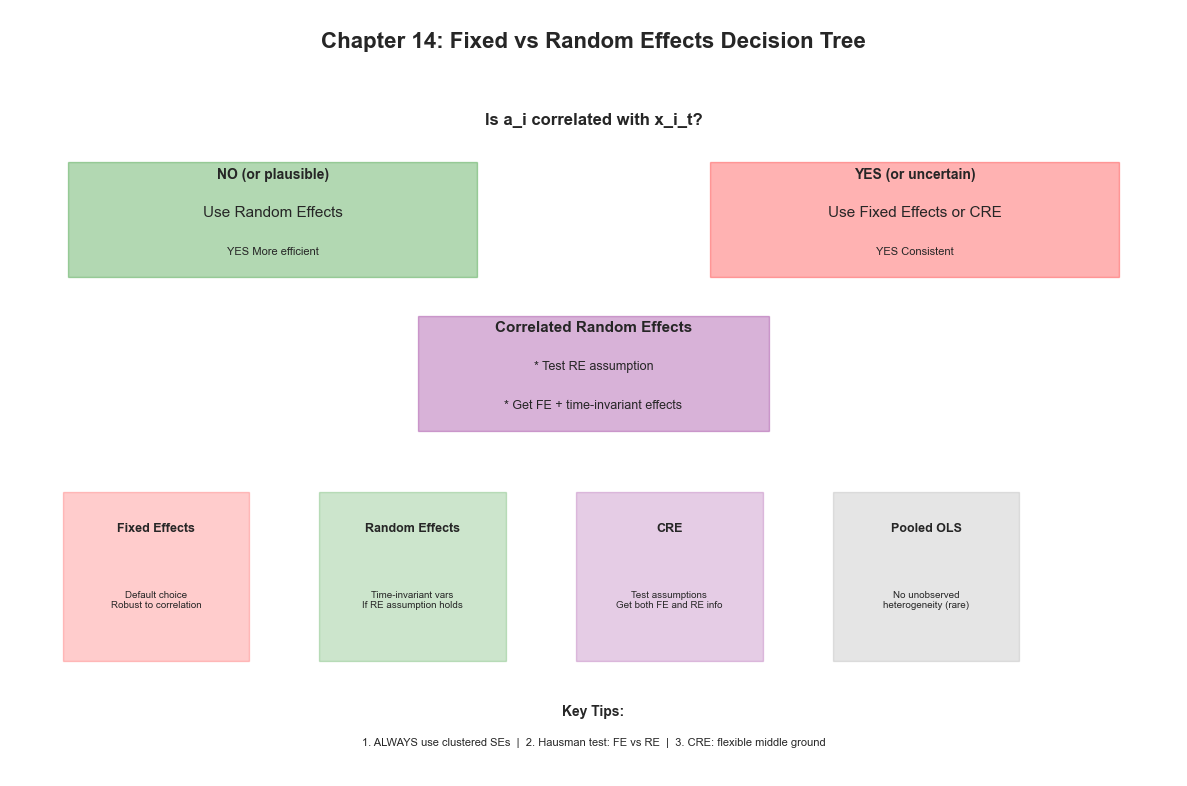

In [25]:
# Visual summary
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis("off")

# Title
ax.text(
    0.5,
    0.95,
    "Chapter 14: Fixed vs Random Effects Decision Tree",
    ha="center",
    fontsize=16,
    fontweight="bold",
)

# Question 1
ax.text(
    0.5, 0.85, "Is a_i correlated with x_i_t?", ha="center", fontsize=12, fontweight="bold"
)

# Branch: No correlation
ax.add_patch(
    plt.Rectangle((0.05, 0.65), 0.35, 0.15, fill=True, alpha=0.3, color="green")
)
ax.text(0.225, 0.78, "NO (or plausible)", ha="center", fontsize=10, fontweight="bold")
ax.text(0.225, 0.73, "Use Random Effects", ha="center", fontsize=11)
ax.text(0.225, 0.68, "YES More efficient", ha="center", fontsize=8)

# Branch: Yes correlation
ax.add_patch(plt.Rectangle((0.6, 0.65), 0.35, 0.15, fill=True, alpha=0.3, color="red"))
ax.text(0.775, 0.78, "YES (or uncertain)", ha="center", fontsize=10, fontweight="bold")
ax.text(0.775, 0.73, "Use Fixed Effects or CRE", ha="center", fontsize=11)
ax.text(0.775, 0.68, "YES Consistent", ha="center", fontsize=8)

# CRE box
ax.add_patch(
    plt.Rectangle((0.35, 0.45), 0.3, 0.15, fill=True, alpha=0.3, color="purple")
)
ax.text(
    0.5, 0.58, "Correlated Random Effects", ha="center", fontsize=11, fontweight="bold"
)
ax.text(0.5, 0.53, "* Test RE assumption", ha="center", fontsize=9)
ax.text(0.5, 0.48, "* Get FE + time-invariant effects", ha="center", fontsize=9)

# Bottom section: When to use what
methods = ["Fixed Effects", "Random Effects", "CRE", "Pooled OLS"]
uses = [
    "Default choice\nRobust to correlation",
    "Time-invariant vars\nIf RE assumption holds",
    "Test assumptions\nGet both FE and RE info",
    "No unobserved\nheterogeneity (rare)",
]
colors = ["red", "green", "purple", "gray"]

for i, (method, use, color) in enumerate(zip(methods, uses, colors, strict=False)):
    x_pos = 0.125 + i * 0.22
    ax.add_patch(
        plt.Rectangle(
            (x_pos - 0.08, 0.15), 0.16, 0.22, fill=True, alpha=0.2, color=color
        )
    )
    ax.text(x_pos, 0.32, method, ha="center", fontsize=9, fontweight="bold")
    ax.text(x_pos, 0.23, use, ha="center", fontsize=7, va="center")

# Bottom tips
ax.text(0.5, 0.08, "Key Tips:", ha="center", fontsize=10, fontweight="bold")
ax.text(
    0.5,
    0.04,
    "1. ALWAYS use clustered SEs  |  2. Hausman test: FE vs RE  |  3. CRE: flexible middle ground",
    ha="center",
    fontsize=8,
)

plt.tight_layout()
plt.show()